# NLP with 20 Newsgroups Dataset

## 1. Introduction

The 20 newsgroups dataset consists of approximately 20000 newsgroups on 20 topics (see [1]), it is split in two subsets: one for training and the other one for testing, the dataset can be imported using the sklearn library (see [2]).
The split between the train and test set is based on a messages posted before and after a specific date.
The data is organized corresponding to different topics, some are closely related (i.e. comp.sys.ibm.pc.hardware and comp.sys.mac.hardware), while others are highly unrelated (e.g. sci.crypt and soc.religion.christian).

The details of the dataset are as follow:

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
print(type(newsgroups_train))
print((newsgroups_train.keys()))
print(newsgroups_train.target_names)
print(newsgroups_train['target'])
print(len(newsgroups_train['data']))
print(len(newsgroups_train['target']))

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
[7 4 4 ... 3 1 8]
11314
11314


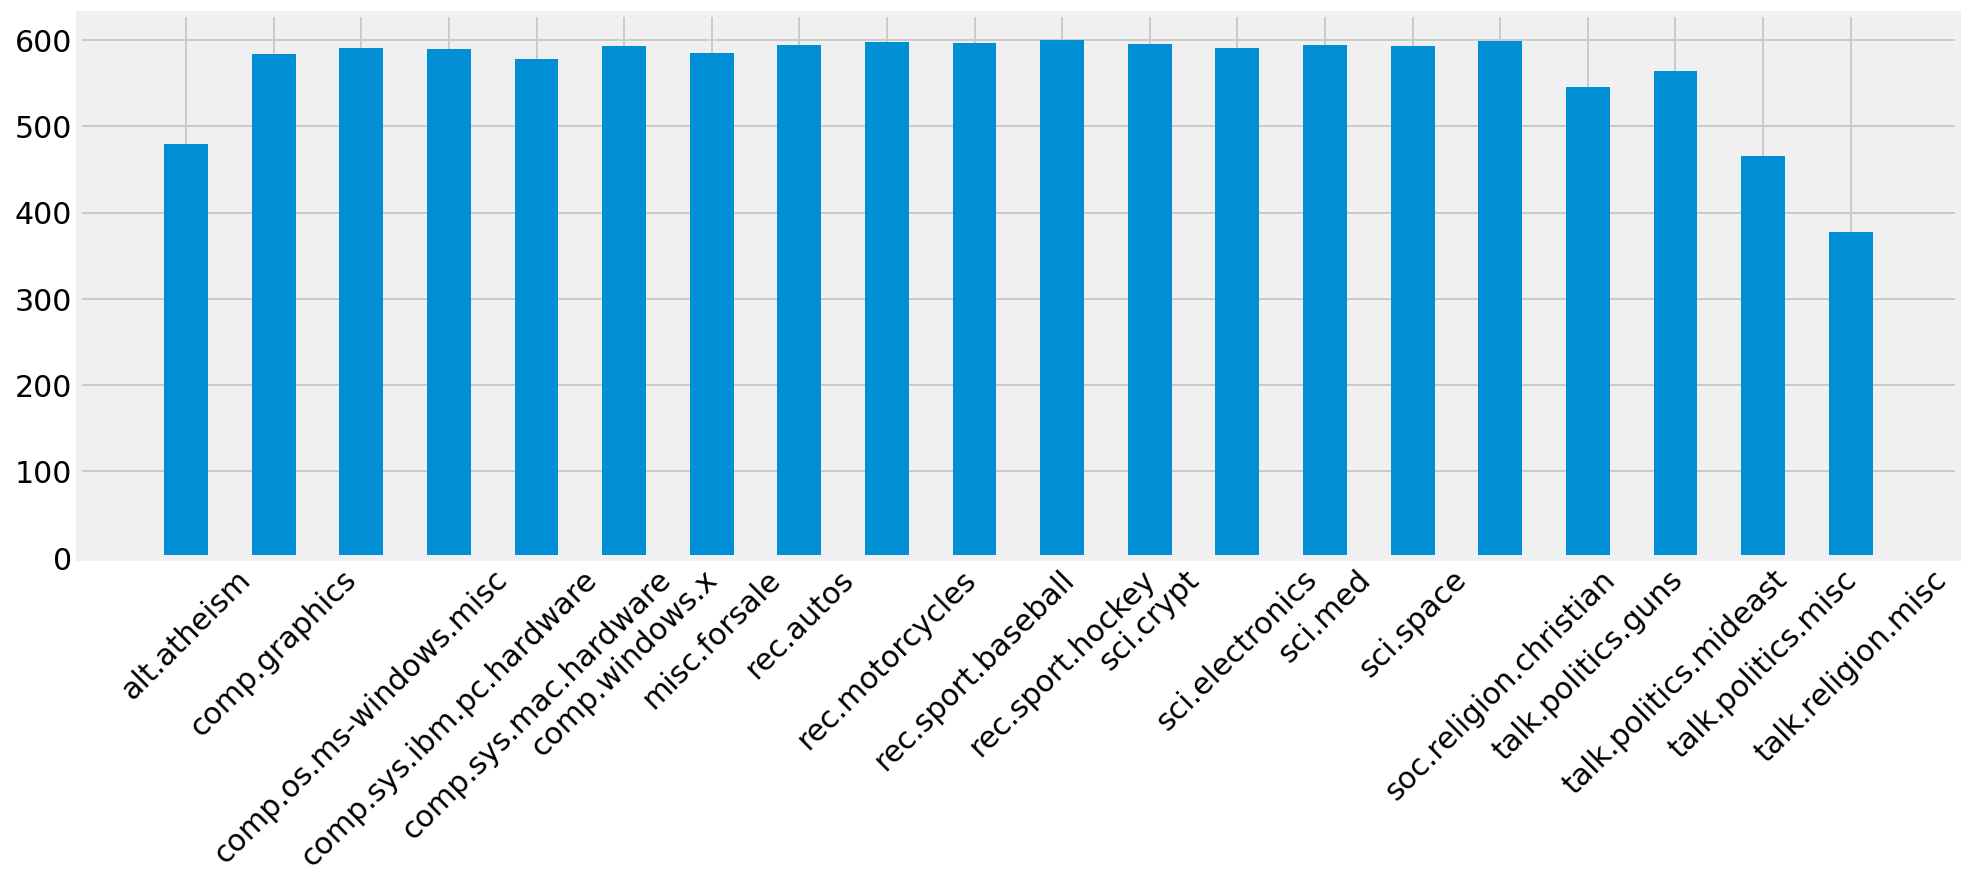

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.figure(figsize = (15,5))
plt.hist(newsgroups_train.target,bins=np.linspace(0,20,21),align='left',rwidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(list(range(20)),newsgroups_train.target_names,fontsize=15,rotation=45)
plt.show()

An example of the data:

In [3]:
print(newsgroups_train['data'][1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



One can implement a simple classifier using the Naive Bayes model (see [3]):

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
news = fetch_20newsgroups()
x_train,x_test,y_train,y_test = train_test_split(news.data,news.target)
model = make_pipeline(TfidfVectorizer(),MultinomialNB()) 
model.fit(x_train,y_train)
prediction = model.predict(x_test)
def predict_category(string,train = x_train, model = model):
	predict = model.predict([string])
	print(news.target_names[predict[0]])
predict_category(newsgroups_train['data'][1])
predict_category('We forgive those who trespass against us and lead us not into temptation, but deliver us from evil')
predict_category('The 2023 CR-V is with both gasoline and hybrid powertrains')
predict_category('The Hubble telescope is still working')
predict_category('Bob wants to sell his house because he needs the money')

comp.sys.mac.hardware
soc.religion.christian
rec.autos
sci.space
rec.sport.baseball


We immediately see that the 5th (a random text I wrote) prediction is not correct (should be 'misc.forsale').

## 2. Initial Implementation

In this project we focus on four categories of the dataset:'alt.atheism', 'talk.religion.misc', 'comp.graphics', and 'sci.crypt'. The headers, footers, and quotes are removed.
Most of the techniques and procedures we use are modified and reprodcued from [4] and [5].

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, utils
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import optimizers
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

First, we take our subset of the dataset:

In [7]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.crypt']
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

### Word Vectorization

It is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector used for predictions. 
The bag-of-words model is a simplified representation of the raw data. In this model, a text is represented as the bag of its words. Bag-of-words representations discard grammar, order, and structure in the text, but track occurances.

One of the features included by CountVectorizer is the stop_words.
In NLP, stop words are words which are filtered out usually after processing our data. 
Though stop_words in this case refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools.

In [8]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(data_train['data'])
cvec_mat = cvec.transform(data_train['data'])
words = cvec.get_feature_names()

The top 5 most common words in the entire dataset are:

In [9]:
a = cvec_mat.sum(axis=0)
pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False).head(5)

,0
people,1027
key,933
don,850
use,782
just,765


The top 5 most common words in the subset Type 2 ('sci.crypt') are:

In [10]:
a = cvec_mat[data_train.target==2].sum(axis=0)
pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False).head(5)

,0
key,906
encryption,551
db,549
use,448
chip,438


We can define the word freqency by the following:

In [12]:
def word_frequency_sorter(words,counts):
    sort_result = sorted(zip(words,list(counts)),key=itemgetter(1),reverse=True)
    return sort_result
csum = np.array(cvec_mat.sum(axis=0))[0]
df_word_frequency = pd.DataFrame(word_frequency_sorter(words,csum),columns=['word','frequency'])
df_word_frequency.head(10)

,word,frequency
0,people,1027
1,key,933
2,don,850
3,use,782
4,just,765
5,like,745
6,god,740
7,does,711
8,know,697
9,think,632


A visulization of the word freqency distribution:

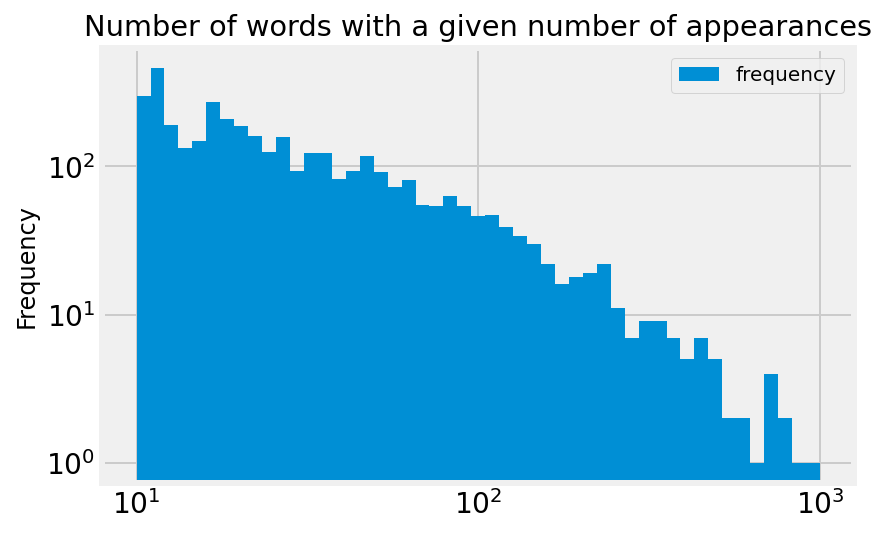

In [13]:
df_word_frequency.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()

## 3. Building Neural Network

We can covert the train and test to dataframes as follows:

In [14]:
df_train = pd.DataFrame(list(zip(data_train.data, data_train.target)), columns=['text', 'label'])
df_train.head(5)

,text,label
0,"\n\nBrian K., guess what? You missed the poin...",3
1,"\nWell, I could use the argument that some her...",0
2,"\nOh, that was just a bet.\n",0
3,\n\n\n\n\n\nI would really appreciate if when ...,3
4,\n\nThey spent quite a bit of time on the word...,0


In [16]:
df_test = pd.DataFrame(list(zip(data_test.data, data_test.target)), columns=['text', 'label'])
df_test.head(5)

,text,label
0,\n\n\n\nThis is a very good point. I have alre...,0
1,"\nYeah, but who wants to start a pool on the f...",2
2,I am writing an article on Clipper for Network...,2
3,,0
4,"\nOr perhaps you write a freely available, GPL...",1


Next we train a neural network with document-term matrix.
In order to feed predictive deep learning models with text data, we use TfidfVectorizer (easier than the CountVectorizer) and create document-term matrices for test and train.

In [17]:
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float16')
    return x 
tfidf = TfidfVectorizer(binary=True)
X_train = tfidf_features(df_train.text.values, flag="train")
X_test = tfidf_features(df_test.text.values, flag="test")

The LabelEncoder converts the list of strings to the matrix of vectors (to feed the neural network model) and encode the list into categorical integer values.

In [18]:
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
y_train = to_categorical(y)
y = lb.transform(df_test.label.values)
y_test = to_categorical(y)

### First Model
We create an input layer with the number of features in X_train, a hidden layer and an output layer.
The number of neurons is set as 4 for the hidden layer and activation function as relu, the output layer activation function is set as softmax.
We train the model with 20 iterations and batch size of 512. 

In [19]:
model = Sequential()
input_dim = X_train.shape[1]
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=20, batch_size=512)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                271960    
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 272,004
Trainable params: 272,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 2s 34ms/step - loss: 0.6904 - accuracy: 0.3463
Epoch 2/20
4/4 [==============================] - 0s 32ms/step - loss: 0.6817 - accuracy: 0.5796
Epoch 3/20
4/4 [==============================] - 0s 32ms/step - loss: 0.6719 - accuracy: 0.7024
Epoch 4/20
4/4 [==============================] - 0s 31ms/step - loss: 0.6616 - accuracy: 0.7824
Epoch 5/20
4/4 [==============================] - 0s 33ms/

Plot the accuracy and loss against epoch:

dict_keys(['loss', 'accuracy'])


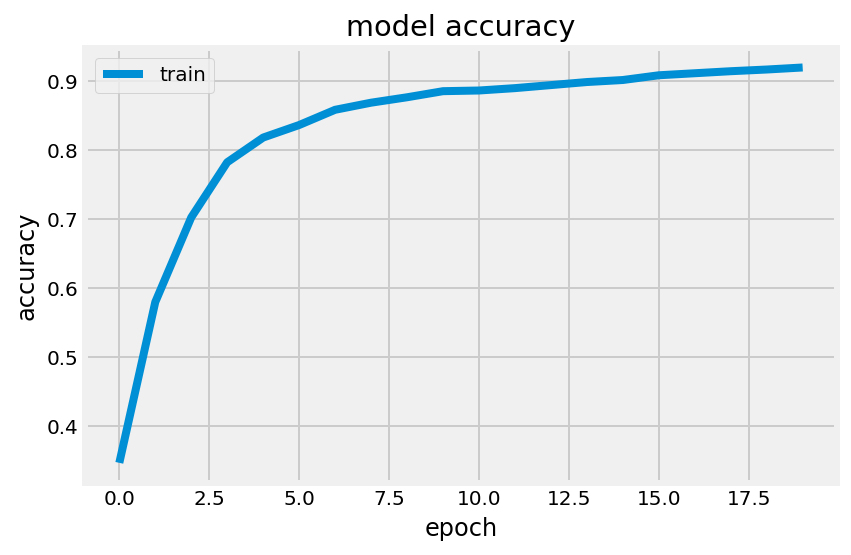

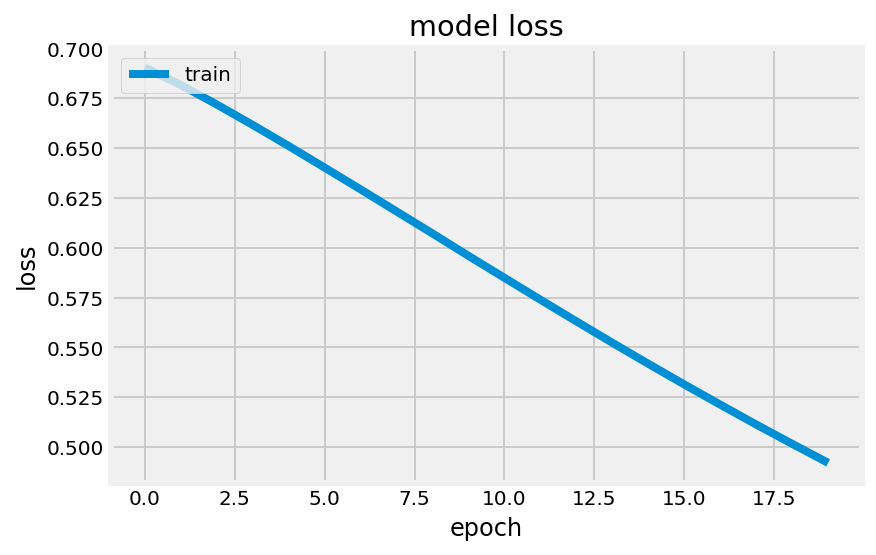

In [20]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss,accuracy))

43/43 [==============================] - 0s 2ms/step - loss: 0.5345 - accuracy: 0.6458
Test set
  Loss: 0.535
  Accuracy: 0.646


This model is overfitting based on the pattern of accuracy/loss.

In [22]:
### Embedding Layer